# Проект по e-commerce 

**Описание проекта:** площадка электронной коммерции занимается продажей товаров различных продавцов и доставкой заказов до конечного покупателя. Все события от создания клиентом заказа до его доставки записываются в 3 таблицы.

**Описание имеющихся данных:**

`customers_df.csv` — **таблица с уникальными идентификаторами пользователей**
    
- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя
    
`orders_df.csv` —  **таблица заказов**

- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

Уникальные статусы заказов в таблице `orders_df`:

* created —  создан
* approved —  подтверждён
* invoiced —  выставлен счёт
* processing —  в процессе сборки заказа
* shipped —  отгружен со склада
* delivered —  доставлен пользователю
* unavailable —  недоступен
* canceled —  отменён

`items_df.csv` —  **товарные позиции, входящие в заказы**

- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

**Вопросы для исследования:**

0. ✅ Что должно считаться покупкой?

1. ✅ Сколько у нас пользователей, которые совершили покупку только один раз?

2. ✅ Сколько заказов в месяц в среднем не доставляется по разным причинам? Вывести детализацию по причинам.

3. ✅ По каждому товару определить, в какой день недели он чаще всего покупается.

4. ✅ Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Учесть, что внутри месяца может быть не целое количество недель (в ноябре 2021 года 4,28 недели). 

5. ✅ Провести когортный анализ пользователей. Какая когорта в период с января по декабрь имела самый высокий retention на 3й месяц?

6. ✅ Провести RFM-сегментацию пользователей. Описать подход к созданию сегментов. Для каждого RFM-сегмента обозначить границы метрик R,F,M.

---
## 🔎 Предварительный анализ данных

#### 0. Загружаем данные

Получаем нужные csv-файлы по ссылкам с Яндекс.Диска с помощью библиотек `urllib` и `requests`, парсим даты как даты

In [1]:
import numpy as np
import pandas as pd 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# библиотеки для скачивания файлов с url
import requests 
from urllib.parse import urlencode

# функция для скачивания файлов с Яндекс Диска
def get_download_url_yandexdisc(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return download_url

In [3]:
customers_df_pk = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders_df_pk = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
items_df_pk = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [4]:
customers_df = pd.read_csv(get_download_url_yandexdisc(customers_df_pk))
orders_df = pd.read_csv(get_download_url_yandexdisc(orders_df_pk), 
                                   parse_dates = [
                                       'order_purchase_timestamp', 
                                       'order_approved_at',
                                       'order_delivered_carrier_date',
                                       'order_delivered_customer_date',
                                       'order_estimated_delivery_date'
                                   ])
items_df = pd.read_csv(get_download_url_yandexdisc(items_df_pk), 
                                        parse_dates = ['shipping_limit_date'])

KeyError: 'href'

Если не работает ссылка с Яндекс.Диска:

In [5]:
customers_df = pd.read_csv('olist_customers_dataset.csv')
orders_df = pd.read_csv('olist_orders_dataset.csv', 
                                   parse_dates = [
                                       'order_purchase_timestamp', 
                                       'order_approved_at',
                                       'order_delivered_carrier_date',
                                       'order_delivered_customer_date',
                                       'order_estimated_delivery_date'
                                   ])
items_df = pd.read_csv('olist_order_items_dataset.csv', 
                                        parse_dates = ['shipping_limit_date'])

#### I. Смотрим на типы данных и на структуру их хранения

Посмотрим на первые строки таблиц, их размер и число уникальных значений по каждому столбцу, чтобы узнать, по какому принципу организовано хранение данных в таблицах. 

`customers_df`:

In [6]:
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
print(customers_df.shape)
pd.DataFrame({'dtypes':customers_df.dtypes, 'nunique':customers_df.nunique()})

(99441, 5)


,dtypes,nunique
customer_id,object,99441
customer_unique_id,object,96096
customer_zip_code_prefix,int64,14994
customer_city,object,4119
customer_state,object,27


В таблице `customers_df`, по всей видимости, первичным ключом является позаказный `customer_id`.

`orders_df`:

In [8]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
print(orders_df.shape)
pd.DataFrame({'dtypes':orders_df.dtypes, 'nunique':orders_df.nunique()})

(99441, 8)


,dtypes,nunique
order_id,object,99441
customer_id,object,99441
order_status,object,8
order_purchase_timestamp,datetime64[ns],98875
order_approved_at,datetime64[ns],90733
order_delivered_carrier_date,datetime64[ns],81018
order_delivered_customer_date,datetime64[ns],95664
order_estimated_delivery_date,datetime64[ns],459


В таблице `orders_df` первичным ключом является `order_id`, но также уникальным идентификатором записей может быть и позаказный `customer_id`, через который связаны первая и вторая таблицы.

`items_df`:

In [10]:
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
print(items_df.shape)
pd.DataFrame({'dtypes':items_df.dtypes, 'nunique':items_df.nunique()})

(112650, 7)


,dtypes,nunique
order_id,object,98666
order_item_id,int64,21
product_id,object,32951
seller_id,object,3095
shipping_limit_date,datetime64[ns],93318
price,float64,5968
freight_value,float64,6999


В таблице `items_df` первичный ключ, видимо, составной: структура хранения данных определяется уникальным  сочетанием `order_id` и `order_item_id` 

In [12]:
len(items_df.groupby(['order_id','order_item_id']).size())

112650

`order_item_id` показывает порядковый номер товара в заказе и тем самым указывает на количество товаров в рамках одного `order_id`. Можно увидеть, что всего в датасете  `items_df` 98666 заказов с хотя бы 1 товаром, и лишь 1 заказ, в котором 21 товар.

In [13]:
items_df.groupby(['order_item_id']).agg({'order_id':'count'})

,order_id
order_item_id,
1,98666
2,9803
3,2287
4,965
5,460
6,256
7,58
8,36
9,28


Далее посмотрим на пропуски и выбросы, на основе чего попытаемся найти **аномалии** в данных.

#### II. Смотрим на пропуски

In [14]:
customers_df.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [15]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [16]:
items_df.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Пропуски есть в таблице `orders_df` в колонках:

* `order_approved_at` — время подтверждения оплаты заказа
* `order_delivered_carrier_date` — время передачи заказа в логистическую службу
* `order_delivered_customer_date` — время доставки заказа клиенту

Можно заметить, что пропуски имеются именно в колонках с датами определенных событий, которые происходят с заказом по мере его выполнения. Логично предположить, что колонка `order_status` содержит информацию о последнем из происшедших с заказом событий, поэтому именно по этой колонке можно лучше всего понять причину пропусков. 

**1. Пропуски в колонке `order_approved_at` (время подтверждения оплаты заказа).** 

По данным заказам не поступила информация по оплате. Почему так могло произойти? Посмотрим на статусы этих заказов.

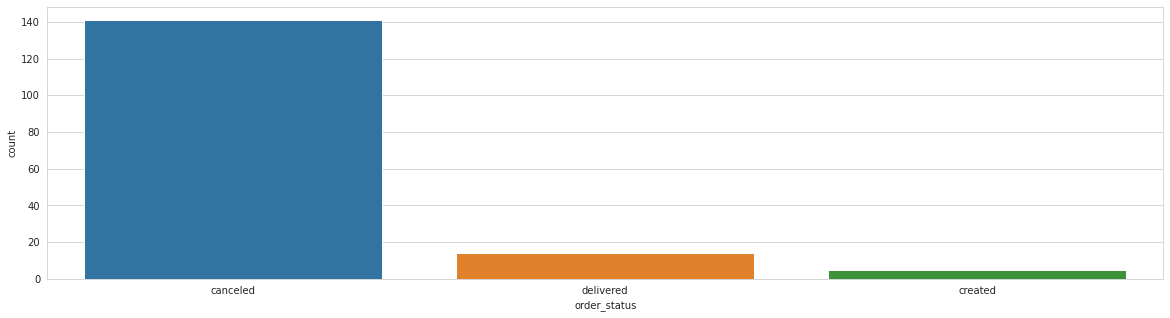

In [17]:
sns.countplot(data=orders_df[orders_df.order_approved_at.isnull()], x="order_status");

In [18]:
orders_df[orders_df.order_approved_at.isnull()] \
    .order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

Пропуски в столбце `order_approved_at` связаны по большей части с отменой заказов, но есть и заказы со статусами `created` и, неожиданно, `delivered`. Казалось бы, статус `delivered` должен появляться уже после доставки, которая, в свою очередь, должна происходить после оплаты. Кроме того, ожидаемо было увидеть среди неоплаченных заказов и заказы со статусом `invoiced`, поскольку данный статус, предположительно, означает, что по заказу ожидается оплата со стороны клиента по выставленному ему счёту.

Очевидно, процесс выполнения заказов не так прост, как казалось. Попробуем выяснить, в каком порядке заполняются даты событий и появляются статусы у большинства заказов. Для этого:
1. Во-первых, посчитаем разницу во времени между датами различных событий
2. Во-вторых, проанализируем заказы с определенным статусом, для которых есть информация о произошедших событиях.

In [19]:
# 1. Оплата-создание
orders_df['diff_approved_created'] = orders_df.order_approved_at - orders_df.order_purchase_timestamp

# 2. Передача в доставку-создание
orders_df['diff_shipped_created'] = orders_df.order_delivered_carrier_date - orders_df.order_purchase_timestamp

# 3. Доставка покупателю-создание
orders_df['diff_delivered_created'] = orders_df.order_delivered_customer_date - orders_df.order_purchase_timestamp

In [20]:
differences = pd.DataFrame(
    {'diff_approved_created':orders_df.diff_approved_created,
     'diff_shipped_created':orders_df.diff_shipped_created,
     'diff_delivered_created':orders_df.diff_delivered_created}
)

In [21]:
differences.describe()

,diff_approved_created,diff_shipped_created,diff_delivered_created
count,99281,97658,96476
mean,0 days 10:25:08.739486910,3 days 05:37:01.944193,12 days 13:24:31.879068369
std,1 days 02:02:16.813098347,3 days 14:41:16.447964018,9 days 13:07:00.181125305
min,0 days 00:00:00,-172 days +18:54:07,0 days 12:48:07
25%,0 days 00:12:54,1 days 03:05:42.750000,6 days 18:23:37.250000
50%,0 days 00:20:36,2 days 04:54:44,10 days 05:13:34
75%,0 days 14:34:51,4 days 01:43:21.500000,15 days 17:17:16.250000
max,187 days 21:10:50,125 days 18:36:45,209 days 15:05:12


В данных наблюдается большой разброс значений: разница между датой создания заказа и датой его доставки варьируется от 0 до 209 дней. Какие-то заказы даже отгружались со склада раньше, чем создавались (что похоже на ошибку в данных). Поэтому мы не будем делать выводы на основе средних значений, но, судя по медианным значениям, доставка заказа клиенту действительно обычно происходит позже, чем оплата заказа.

Теперь проанализируем соответствие между различными статусами заказов и событиями:

In [22]:
# колонки с датами событий
dates_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']

#  количество заказов с разными статусами: тотал
not_nulls_by_status = orders_df.groupby(['order_status']) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'total_status_count'})
not_nulls_by_status

,total_status_count
order_status,
approved,2
canceled,625
created,5
delivered,96478
invoiced,314
processing,301
shipped,1107
unavailable,609


In [23]:
# считаем, сколько заказов с разными статусами имеют ненулевые значения в колонках с разными датами 
not_nulls_by_status_t = not_nulls_by_status.merge(orders_df.groupby(['order_status']) \
                                                  .count()[dates_cols], left_index = True, right_index = True) \
                                                  .T[['created', 'approved', 'invoiced', 'processing', 'shipped', 'delivered','canceled','unavailable']]
not_nulls_by_status_t

order_status,created,approved,invoiced,processing,shipped,delivered,canceled,unavailable
total_status_count,5,2,314,301,1107,96478,625,609
order_purchase_timestamp,5,2,314,301,1107,96478,625,609
order_approved_at,0,2,314,301,1107,96464,484,609
order_delivered_carrier_date,0,0,0,0,1107,96476,75,0
order_delivered_customer_date,0,0,0,0,0,96470,6,0


По этой таблице видно, в каком порядке появляются статусы у основной массы заказов. 
* Можно заметить, что, например, существует всего 5 заказов со статусом `created`, все они имеют заполненную дату `order_purchase_timestamp`, но остальные колонки с датами у заказов с этим статусом пустые. Значит, этот статус появляется первым по порядку вместе с датой `order_purchase_timestamp`. 
* Аналогично, в датасете 1107 заказов со статусом `shipped` (отгружены со склада), и все они уже переданы в логистическую службу, следовательно, данные статус и событие связаны друг с другом. При этом логично, что, если заказы состоят из товаров различных продавцов, сборка заказов (`processing`) осуществляется на складе нашей площадки, а затем каждый заказ передается в нашу логистическую службу.

Вопреки ожиданиям, все заказы со статусом `invoiced` имеют подтвержденную оплату со стороны клиента. Следовательно, этот статус отвечает не за выставление e-com площадкой счёта на оплату конечному клиенту, а, гипотетически, за выставление счёта продавцом товара нашей площадке с требованием вернуть причитающуюся продавцу часть выручки за проданные товары. Эту **гипотезу** следует проверить, обратившись к команде продаж, поскольку для больших e-commerce площадок более характерно переводить платежи продавцам в автоматическом режиме на регулярной основе за определенный период времени, а не рассчитываться за каждый заказ по требованию продавца.

Итак, по основной массе данных можно сделать вывод:


|№  | **Статус** | **Соответствует дате**
|---|---         | --- 
|1  |`created`   | `order_purchase_timestamp`
|2  |`approved`  | `order_approved_at`
|3  |`invoiced`  | **после** `order_approved_at`, **до** `order_delivered_carrier_date`
|4  |`processing`  | **после** `order_approved_at`, **до** `order_delivered_carrier_date`
|5  |`shipped`  | `order_delivered_carrier_date`
|6  |`delivered`  | `order_delivered_customer_date	`

* `canceled` может возникнуть в любой момент времени: до оплаты заказа, перед передачей заказа партнеру по логистике, незадолго перед доставкой клиенту и даже после нее. 
* `unavailable` возникает на том же этапе, что и статусы `invoiced` и `processing`. Скорее всего, это значит, что товар не в наличии, поэтому в службу доставки передавать нечего.

Вернемся к  пропускам в столбце `order_approved_at`. Теперь ясно, что статус `delivered` находится не на своем месте. Посмотрим внимательнее на эти 14 заказов.

In [24]:
orders_df[orders_df.order_approved_at.isnull()] \
    .query('order_status == "delivered"') \
    .sort_values(by = 'order_purchase_timestamp', ascending = False)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_approved_created,diff_shipped_created,diff_delivered_created
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,NaT,4 days 01:43:01,11 days 02:13:11
67697,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21,NaT,3 days 12:41:47,11 days 13:16:47
84999,2babbb4b15e6d2dfe95e2de765c97bce,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31,NaT,3 days 18:08:08,13 days 01:28:40
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,NaT,3 days 18:34:35,18 days 14:40:12
63052,51eb2eebd5d76a24625b31c33dd41449,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,NaT,4 days 11:16:47,16 days 22:05:20
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,NaT,4 days 21:24:47,10 days 22:45:33
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,NaT,4 days 02:55:38,10 days 18:37:51
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,NaT,4 days 20:16:21,11 days 21:19:35
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,NaT,4 days 20:19:17,12 days 05:11:04
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,NaT,4 days 18:20:56,13 days 18:54:08


**Гипотезы**: 
1. По delivered-заказам с пропуском в `order_approved_at` работает модель пост-оплаты: оплата после доставки, при получении
2. Пользователь не принял заказ даже после доставки в силу каких-то причин и не заплатил
3. Закралась ошибка в логах: заказ либо на самом деле не доставлен, либо уже доставлен и оплачен

В первых двух случаях в базе данных, скорее всего, со временем появилась бы информация либо о получении оплаты (`order_approved_at`), либо об отмене заказа (`order_status = canceled`). Однако на руках у нас лишь выгрузка данных за определенный период, в которой по этим заказам нет более актуальной информации (потому что все `order_id` в датасете `orders_df` уникальны). Но если эти заказы появились, по меркам датасета, совсем недавно, первые две гипотезы отвергнуть нельзя. 

Проверим, за какое время хранятся данные в нашем датасете: 

In [25]:
orders_df.select_dtypes(include=['datetime64']).describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
unique,98875,90733,81018,95664,459
top,2018-03-31 15:08:21,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,3,9,47,3,522
first,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


Данные в датасете `orders_df` представлены за 2 года: с сентября-октября 2016 по сентябрь-октябрь 2018. В то же время все 14 заказов с пропусками в `order_approved_at` и статусом `delivered` были созданы в январе-феврале 2017 года, поэтому нельзя предположить, что в них возможны какие-то изменения. 

Действительно, можно заметить, что 14 подозрительных заказов сосредоточены в относительно небольшом промежутке времени. Поэтому возникает еще одна **гипотеза:**
4. Не случалось ли в этот промежуток времени время массовых сбоев при логировании?

In [26]:
between_dates_logs = orders_df.query('(order_purchase_timestamp >= "2017-01-19 12:48:08") and (order_purchase_timestamp <= "2017-02-19 01:28:47")') \
    .sort_values(by = 'order_purchase_timestamp', ascending = False)
print('Записей за период: ',between_dates_logs.shape[0])
pd.DataFrame(
    {'diff_approved_created':between_dates_logs.diff_approved_created,
     'diff_shipped_created':between_dates_logs.diff_shipped_created,
     'diff_delivered_created':between_dates_logs.diff_delivered_created}
).describe()

Записей за период:  1847


,diff_approved_created,diff_shipped_created,diff_delivered_created
count,1831,1745,1720
mean,0 days 10:18:08.187875477,3 days 11:24:21.492263610,12 days 13:41:11.837209302
std,1 days 15:11:51.542406988,4 days 15:06:34.897969424,9 days 08:41:58.131471438
min,0 days 00:05:42,0 days 00:15:33,1 days 02:39:47
25%,0 days 00:11:08,0 days 22:53:09,7 days 05:48:32.750000
50%,0 days 00:14:25,2 days 03:12:37,10 days 13:58:16
75%,0 days 12:36:37,3 days 23:32:33,14 days 21:15:53.500000
max,60 days 10:51:59,54 days 22:02:41,130 days 16:20:35


In [27]:
between_dates_logs.order_approved_at.isna().sum()

16

**Вывод:** нет, в данный период не наблюдалось всплеска нетипичных данных, а также большого количества пропусков по столбцу `order_approved_at`.
За неимением альтернатив мы делаем вывод в пользу гипотезы №3 — эти заказы можно отнести к **аномалиям.**

**Аномалиями** будем считать наблюдения, характеристики которых нетипичны для основной массы данных и которые нельзя однозначно объяснить в рамках имеющейся информации и принятых на основе нее допущений, либо наблюдения, которые однозначно можно отнести к ошибкам.

Проверим датасет на более "очевидные" аномалии — те, что можно точно отнести к ошибкам:
1. Заказ оплачен раньше, чем создан
2. Заказ передан в доставку раньше, чем создан
3. Заказ доставлен покупателю раньше, чем создан
4. Заказ обещали доставить раньше, чем заказ был создан
5. Заказ доставлен покупателю раньше, чем передан в доставку

И создадим дополнительные переменные для их отслеживания (для отслеживания первых 3-х аномалий достаточно переменных, которые мы уже создавали: `diff_approved_created`, `diff_shipped_created`, `diff_delivered_created`).

In [28]:
# 4. Обещанная дата доставки-создание
orders_df['diff_estimated_created'] = orders_df.order_estimated_delivery_date - orders_df.order_purchase_timestamp

# 5. Доставка покупателю-передача в доставку
orders_df['diff_delivered_shipped'] = orders_df.order_delivered_customer_date - orders_df.order_delivered_carrier_date

Таких аномалий в датасете 189:

In [29]:
orders_df[
    (
        orders_df['diff_approved_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_shipped_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_delivered_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_estimated_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_delivered_shipped'] < pd.Timedelta(0)
    )
].order_id.count()

189

In [30]:
anomalies = orders_df[
    (
        orders_df['diff_approved_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_shipped_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_delivered_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_estimated_created'] < pd.Timedelta(0)
    ) | (
        orders_df['diff_delivered_shipped'] < pd.Timedelta(0)
    )
]

Включим в список аномалий заказы с пропусками в `order_approved_at` и со статусом `delivered`.

In [31]:
anomalies = anomalies.append(
    orders_df[orders_df.order_approved_at.isnull()] \
    .query('order_status == "delivered"')
)

In [32]:
anomalies.shape

(203, 13)

**2. Пропуски в колонке `order_delivered_carrier_date` (время передачи заказа в логистическую службу)**

По этим заказам не была получена информация, что они были переданы в службу доставки e-com площадки. Посмотрим на статусы этих заказов. 

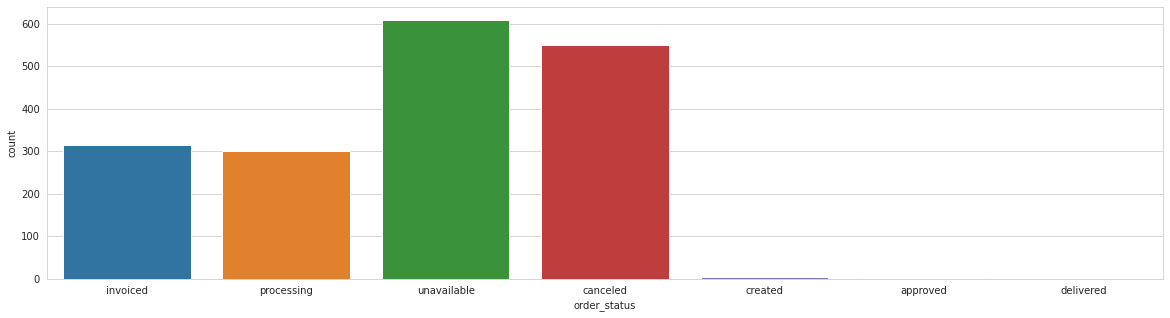

In [33]:
sns.countplot(data=orders_df[orders_df.order_delivered_carrier_date.isnull()], x="order_status");

In [34]:
orders_df[orders_df.order_delivered_carrier_date.isnull()] \
    .order_status.value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: order_status, dtype: int64

Большинство из таких заказов — отменены, либо недоступны, либо на них только выставлен счет, какие-то заказы в процессе сборки, какие-то только созданы, какие-то только оплачены. Однако здесь также есть заказы со статусом `delivered`, которые перед этим не были переданы в доставку. Почему такое могло произойти?
Посмотрим на эти 2 заказа.

In [35]:
orders_df[
    (orders_df.order_delivered_carrier_date.isnull())
    & (orders_df.order_status == 'delivered')
]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,0 days 00:14:18,NaT,52 days 10:51:49,45 days 15:07:02,NaT
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,0 days 00:07:33,NaT,NaT,28 days 00:37:17,NaT


* Заказ с id = `2aa91108853cecb43c84a5dc5b277475` был доставлен покупателю, хотя и с опозданием. Возможно, этот заказ доставлялся службой доставки самого продавца, хотя этот случай единичный. Именно из-за того, что этот случай единственный и он нарушает логику процесса выполнения заказа, которую мы установили ранее, предположим, что это все-таки ошибка и отнесем этот заказ к аномалиям.
* Заказ с id = `2d858f451373b04fb5c984a1cc2defaf` вовсе не был доставлен конечному клиенту, хотя статус доставки стоит. Это, безусловно, аномалия, и такие случаи мы будем проверять в 3 пункте работы с пропусками: по полю `order_delivered_customer_date`

In [36]:
anomalies = anomalies.append(orders_df.query('order_id == "2aa91108853cecb43c84a5dc5b277475"'))
anomalies.shape

(204, 13)

**3. Пропуски в колонке `order_delivered_customer_date` (время доставки заказа клиенту)**

По этим заказам не была получена информация о доставке конечному клиенту. Посмотрим на статусы этих заказов. 

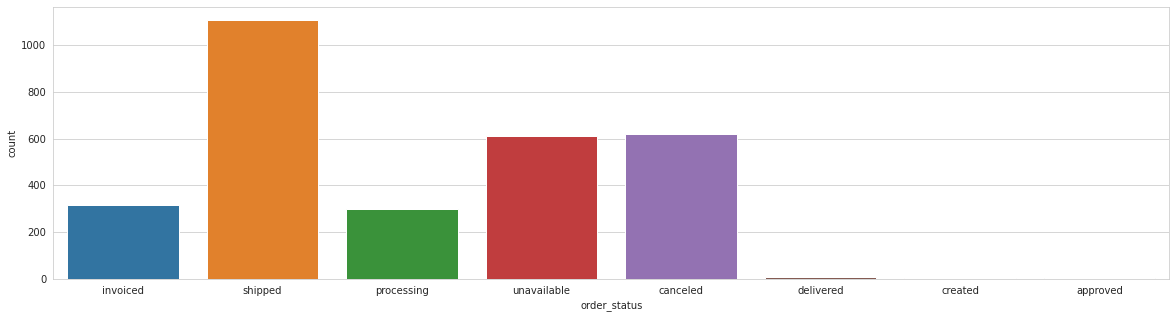

In [37]:
sns.countplot(data=orders_df[orders_df.order_delivered_customer_date.isnull()], x="order_status");

In [38]:
orders_df[orders_df.order_delivered_customer_date.isnull()] \
    .order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

Опять же, большая часть таких заказов имеет промежуточный статус, поэтому неудивительно, что по ним отсутствует дата доставки конечному покупателю. Однако 8 заказов имеют статус `delivered`, что, очевидно, является аномалией.

In [39]:
orders_df[(orders_df.order_delivered_customer_date.isnull()) & (orders_df.order_status == 'delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,0 days 00:12:33,2 days 00:28:16,NaT,19 days 06:15:53,NaT
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,0 days 00:20:22,5 days 01:06:17,NaT,25 days 17:01:17,NaT
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,0 days 00:10:01,1 days 20:51:49,NaT,28 days 06:54:49,NaT
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,0 days 00:09:19,1 days 15:51:05,NaT,28 days 01:54:05,NaT
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,0 days 00:15:52,1 days 12:13:58,NaT,22 days 02:45:58,NaT
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,0 days 00:07:33,NaT,NaT,28 days 00:37:17,NaT
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,0 days 00:27:00,4 days 02:00:21,NaT,17 days 11:50:21,NaT
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,0 days 00:20:18,6 days 03:16:48,NaT,21 days 07:50:48,NaT


Проверяем, включены ли эти заказы в список аномальных:

In [40]:
delivered_not_delivered = list(orders_df[(orders_df.order_delivered_customer_date.isnull()) & (orders_df.order_status == 'delivered')].order_id)
anomalies.order_id.isin(delivered_not_delivered).sum()

0

Включаем:

In [41]:
anomalies = anomalies.append(orders_df[
    (
        orders_df.order_delivered_customer_date.isnull()
    ) & (
        orders_df.order_status == 'delivered'
    )
])
anomalies.shape

(212, 13)

#### Удалим аномалии из данных
Перед работой с выбросами удалим аномалии из наших датасетов.

In [42]:
anomalies_order_ids = list(anomalies.order_id)
anomalies_customer_ids = list(anomalies.customer_id)

In [43]:
customers_df = customers_df[customers_df.customer_id.isin(anomalies_customer_ids) == False]
customers_df.shape

(99229, 5)

In [44]:
orders_df = orders_df[orders_df.order_id.isin(anomalies_order_ids) == False]
orders_df.shape

(99229, 13)

In [45]:
items_df = items_df[items_df.order_id.isin(anomalies_order_ids) == False]
items_df.shape

(112389, 7)

#### III. Смотрим на выбросы

Ранее мы заметили, что в датасете `orders_df` в колонках с разницей во времени между событиями наблюдается большой разброс значений. Причина в том, что в этих колонках присутствуют **выбросы**. Так, по колонке `diff_approved_created` видно, что 75% заказов оплачивались в срок до 14 часов после их создания, а максимальное значение по этой колонке — 187 дней.

In [46]:
diffs = ['diff_approved_created','diff_shipped_created','diff_delivered_created','diff_estimated_created','diff_delivered_shipped']
orders_df[diffs].describe()

,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
count,99083,97448,96273,99229,96273
mean,0 days 10:26:02.842051613,3 days 05:44:58.847857318,12 days 13:38:36.407923301,23 days 18:24:28.105503431,9 days 08:02:41.155318729
std,1 days 02:03:28.563368359,3 days 13:36:23.841620277,9 days 13:12:51.513466598,8 days 19:51:00.938947647,8 days 17:56:23.270068474
min,0 days 00:00:00,0 days 00:00:32,0 days 12:48:07,1 days 15:34:33,0 days 00:00:00
25%,0 days 00:12:54,1 days 03:09:47.750000,6 days 18:36:42,18 days 08:00:45,4 days 02:24:45
50%,0 days 00:20:37,2 days 04:59:02.500000,10 days 05:24:54,23 days 05:48:02,7 days 02:25:04
75%,0 days 14:36:41,4 days 01:44:41,15 days 17:35:04,28 days 10:10:49,12 days 00:48:10
max,187 days 21:10:50,125 days 18:36:45,209 days 15:05:12,155 days 03:15:04,205 days 04:35:00


In [47]:
diffs_days = orders_df[diffs] / pd.Timedelta(days=1)
diffs_days.head()

,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
0,0.007431,2.373924,8.436574,15.544063,6.062650
1,1.279745,1.742627,13.782037,19.137766,12.039410
2,0.011505,0.216100,9.394213,26.639711,9.178113
3,0.012419,3.758252,13.208750,26.188819,9.450498
4,0.042940,0.936053,2.873877,12.112049,1.937824


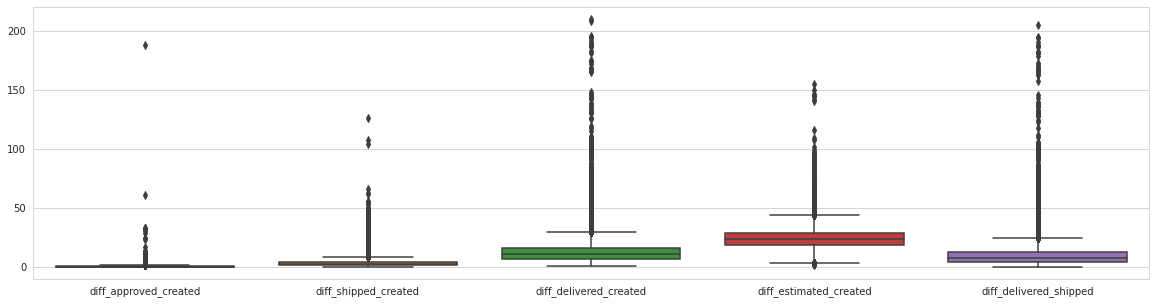

In [48]:
sns.boxplot(data = diffs_days);

`boxplot` считает выбросами данные, которые находятся:
* выше верхнего квартиля и межквартильного размаха (IQR): $ Q3+IQR $
* ниже нижнего квартиля и IQR: $ Q1-IQR $

Попробуем найти эти выбросы:

In [49]:
all_outliers = pd.DataFrame()
for i in orders_df[diffs]:
    q1 = orders_df[i].quantile(0.25)
    q3 = orders_df[i].quantile(0.75)
    iqr = q3-q1
    all_outliers = all_outliers.append(orders_df[(orders_df[i] > q3 + iqr) | (orders_df[i] < q1 - iqr)])

In [50]:
all_outliers.shape

(44991, 13)

Поскольку под эти критерии попадает около половины всех данных, будем придерживаться менее строгого подхода. Распределение данных у нас сильно скошено вправо, поэтому выбросами будем считать те наблюдения, по которым разница между событиями больше, чем у 99,9% данных, либо меньше, чем у 0,1% данных.

In [51]:
all_outliers = pd.DataFrame()
for i in orders_df[diffs]:
    q_999 = orders_df[i].quantile(0.999)
    q_01 = orders_df[i].quantile(0.001)
    all_outliers = all_outliers.append(orders_df[(orders_df[i] > q_999) | (orders_df[i] < q_01)])

In [52]:
all_outliers.describe()

,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
count,883,859,850,884,850
mean,1 days 19:50:40.199320498,11 days 02:04:31.143189755,42 days 09:09:25.200000,30 days 03:35:34.926470588,31 days 12:31:03.969411764
std,7 days 18:09:46.793631717,17 days 15:39:07.184121254,51 days 23:19:43.883877256,24 days 10:28:54.610528858,51 days 11:21:27.181672041
min,0 days 00:00:00,0 days 00:00:32,0 days 12:48:07,1 days 15:34:33,0 days 00:00:00
25%,0 days 00:12:37.500000,0 days 14:49:58.500000,3 days 22:27:46,13 days 15:48:13,1 days 00:24:25.500000
50%,0 days 00:21:28,3 days 03:51:32,16 days 13:41:48,24 days 20:35:26.500000,6 days 06:32:10
75%,0 days 22:31:42,12 days 16:01:17,68 days 20:41:23.250000,36 days 07:58:42,23 days 17:19:37
max,187 days 21:10:50,125 days 18:36:45,209 days 15:05:12,155 days 03:15:04,205 days 04:35:00


Следует ли относить эти наблюдения к аномалиям? На основе имеющихся данных и здравого смысла сложно предположить, по какой причине (кроме как по ошибке) могли появиться заказы, которые:
* оплачивались в течение 187 дней или около того после создания *(при том, что на современных маркетплейсах заказ автоматически отменяется, если не была внесена оплата в течение нескольких минут)*
* обрабатывались на складе около 125 дней или, наоборот, всего в течение 32 секунд после появления заказа
* доставлялись до пользователя более 200 дней (*при том, что в датасетах нет информации о стране заказчика, так что все действия, вероятно, происходили в одной стране, и, судя по названиям городов, это Бразилия)* или в один момент с отгрузкой со склада *(если только клиент не ждал своего заказа в распределительном центре, что также крайне странно)*

В связи с этой логикой удалим наши выбросы из данных:

In [53]:
outliers_orders_ids = list(all_outliers.order_id)
outliers_customer_ids = list(all_outliers.customer_id)

In [54]:
customers_df = customers_df[customers_df.customer_id.isin(outliers_customer_ids) == False]
customers_df.shape

(98457, 5)

In [55]:
orders_df = orders_df[orders_df.order_id.isin(outliers_orders_ids) == False]
orders_df.shape

(98457, 13)

In [56]:
items_df = items_df[items_df.order_id.isin(outliers_orders_ids) == False]
items_df.shape

(111517, 7)

Посмотрим на оставшиеся данные

In [57]:
orders_df.describe()

,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
count,98312,96701,95534,98457,95534
mean,0 days 10:08:26.417578728,3 days 04:23:56.954571307,12 days 10:07:49.283155735,23 days 17:14:29.264328590,9 days 05:50:38.090637888
std,0 days 19:13:34.807515790,3 days 05:35:43.989790489,8 days 15:24:38.032827207,8 days 13:12:51.375156445,7 days 21:58:48.861275216
min,0 days 00:00:00,0 days 00:26:34,1 days 03:31:58,2 days 09:17:05,0 days 09:05:34
25%,0 days 00:12:54,1 days 03:13:48,6 days 19:00:04,18 days 08:19:03,4 days 02:45:29.500000
50%,0 days 00:20:36,2 days 04:56:36,10 days 05:20:34,23 days 05:45:53,7 days 02:31:02.500000
75%,0 days 14:34:52.750000,4 days 01:29:46,15 days 15:58:55,28 days 09:47:58,12 days 00:44:57.250000
max,6 days 10:01:19,37 days 01:40:37,83 days 00:02:17,67 days 02:00:18,76 days 04:06:32


Кроме этого, мы помним, что часть заказов имеет "промежуточные" статусы: `created`, `approved`, `invoiced`, `processing`, `shipped`. Поскольку по ним часть событий не произошла, такие заказы нужно проанализировать отдельно. Посмотрим, в какие даты создавались эти заказы.

In [58]:
transitional_statuses = orders_df.query('(order_status == "created") or (order_status == "approved") or (order_status == "invoiced") or (order_status == "processing")  or (order_status == "shipped")') \
    .sort_values(by='order_purchase_timestamp', ascending = True)
pd.concat([transitional_statuses.head(3), transitional_statuses.tail(3)])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_approved_created,diff_shipped_created,diff_delivered_created,diff_estimated_created,diff_delivered_shipped
78824,dd359d3c294458c6d642b2eea9212bf5,5c58d1ea5a893380ecdd96dd6dfd5ec5,invoiced,2016-10-04 13:02:10,2016-10-05 03:08:27,NaT,NaT,2016-11-24,0 days 14:06:17,NaT,NaT,50 days 10:57:50,NaT
24222,711b9be9c346d9ecdb9d38a5e1e7e39b,81e4aed5ab4253757305267b80712689,invoiced,2016-10-04 13:38:37,2016-10-04 14:08:38,NaT,NaT,2016-11-24,0 days 00:30:01,NaT,NaT,50 days 10:21:23,NaT
18535,5cb8558cbb7c0c2f00f43468579d3e3c,2ff5a6455514da421bd25d6e4ceb1d12,shipped,2016-10-04 15:02:37,2016-10-05 03:10:59,2016-10-15 10:14:10,NaT,2016-12-02,0 days 12:08:22,10 days 19:11:33,NaT,58 days 08:57:23,NaT
24944,99b3fb1a943fa5d4af2a3386f00fdd19,aa03e52d50af7237a5963ffb09dd8872,shipped,2018-08-22 09:01:17,2018-08-22 09:10:17,2018-08-23 14:09:00,NaT,2018-08-30,0 days 00:09:00,1 days 05:07:43,NaT,7 days 14:58:43,NaT
22575,6ca46f2b9a1592929647682510800e0e,13bf775a749925a15ef7cc1985b564f1,shipped,2018-08-24 17:02:19,2018-08-24 17:15:10,2018-08-27 15:15:00,NaT,2018-08-29,0 days 00:12:51,2 days 22:12:41,NaT,4 days 06:57:41,NaT
62360,54282e97f61c23b78330c15b154c867d,4b7decb9b58e2569548b8b4c8e20e8d7,shipped,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-04 15:25:00,NaT,2018-09-06,0 days 08:33:09,1 days 06:18:03,NaT,2 days 14:53:03,NaT


При том, что в датасете, как мы выяснили, данные представлены за 2 года (2016-2018), можно заметить, что какие-то заказы имеют неизменный промежуточный статус с 2016 года.

Почему так могло произойти? **Гипотезы:** 

1. Данные выгружались из баз данных случайным образом, поэтому в датасетах представлена неполная информация по заказам: мы видим устаревшие логи, в то время как в оригинальной базе данных есть более актуальная информация. 
2. Данные выгружались из баз данных целиком и полностью, но в связи с ошибками при логировании данные по части заказов не обновлялись, поэтому по этим заказам не существует достоверной информации.

Первую гипотезу подтвердить не получится, поскольку мы не имеем доступа к обновляемым базам данных, на основе которых сформированы наши датасеты. Если следовать второй гипотезе, то нам придется отделить "старые" заказы с ошибками при логировании (иными словами, аномалии) от актуальных заказов, которые на момент создания датасета действительно имели "промежуточный" статус, и удалить первый тип данных.

Как это сделать?
1. Изучаем, насколько "старыми" являются "промежуточные" заказы: находим разницу между `order_purchase_timestamp` и текущей датой (т.е. самой последней фактической датой в нашем датасете) у заказов с промежуточным статусом.
2. Смотрим предельные сроки исполнения "нормальных" заказов: находим предельно допустимую разницу между `order_purchase_timestamp` и `order_delivered_customer_date` у доставленных заказов. Поскольку ранее мы очистили датасет от выбросов, предельно допустимой разницей между этими событиями будет максимум по колонке `diff_delivered_created`
3. Если разница [2] превышает разницу [1], такой "промежуточный" заказ считаем аномалией.

In [59]:
# текущая дата
now_date = orders_df[dates_cols].max().max()
print(orders_df[dates_cols].max())
print('текущей датой будем считать: ', now_date)

order_purchase_timestamp        2018-10-17 17:30:18
order_approved_at               2018-09-03 17:40:06
order_delivered_carrier_date    2018-09-11 19:48:28
order_delivered_customer_date   2018-10-02 00:18:50
dtype: datetime64[ns]
текущей датой будем считать:  2018-10-17 17:30:18


In [60]:
# разница между текущей датой и датой создания заказа с промежуточным статусом
transitional_statuses['diff_now_created'] = now_date - transitional_statuses.order_purchase_timestamp
pd.DataFrame(transitional_statuses['diff_now_created'].describe())

,diff_now_created
count,1714
mean,339 days 02:52:44.234539088
std,165 days 08:30:01.488311476
min,44 days 08:23:21
25%,207 days 22:15:32.500000
50%,322 days 01:00:07.500000
75%,476 days 03:29:54.500000
max,743 days 04:28:08


In [61]:
# предельно допустимая разница между датой создания заказа и датой доставки
max_diff_delivered_created = orders_df.diff_delivered_created.max()
max_diff_delivered_created

Timedelta('83 days 00:02:17')

In [62]:
anomalies_transitional = transitional_statuses[transitional_statuses.diff_now_created > max_diff_delivered_created]
anomalies_transitional.shape

(1632, 14)

Следуя второй гипотезе, можно заключить, что аномалиями оказалось большинство "промежуточных" заказов.

---
Также на выбросы можно проверить 2 колонки с числовыми данными из датасета `items_df`: `price` (цена) и `freight_value` (вес товара). Единицы измерения их нам неизвестны, но общую тенденцию оценить можно:

In [63]:
items_df[['price','freight_value']].describe()

,price,freight_value
count,111517.000000,111517.000000
mean,120.574583,19.985904
std,183.400213,15.784593
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.900000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


Цена 6000+ денежных единиц (возможно, бразильских реалов) выбивается из общей массы данных, но с учетом, что этот товар весил около 200 у.е. (при среднем значении 20 у.е.), вероятно, никакой ошибки тут нет. Аналогичный вывод можно сделать и про максимальное значение веса.

In [64]:
items_df.query('(price == 6735.000000) or (freight_value == 409.680000)')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
3556,0812eb902a67711a1cb742b3cdaa65ae,1,489ae2aa008f021502940f251d4cce7f,e3b4998c7a498169dc7bce44e6bb6277,2017-02-16 20:37:36,6735.0,194.31
73486,a77e1550db865202c56b19ddc6dc4d53,1,ec31d2a17b299511e7c8627be9337b9b,257e61d3251fb5efb9daadddbc2cf7ca,2018-04-25 06:55:13,979.0,409.68


Не будем относить эти данные к выбросам.

---
Вновь очищаем наши датасеты от аномалий.

In [65]:
anomalies_order_ids = list(anomalies_transitional.order_id)
anomalies_customer_ids = list(anomalies_transitional.customer_id)

In [66]:
customers_df = customers_df[customers_df.customer_id.isin(anomalies_customer_ids) == False]
print(customers_df.shape)

(96825, 5)


In [67]:
orders_df = orders_df[orders_df.order_id.isin(anomalies_order_ids) == False]
print(orders_df.shape)
orders_df.order_status.value_counts()

(96825, 13)


delivered      95528
canceled         609
unavailable      606
shipped           57
invoiced          25
Name: order_status, dtype: int64

In [68]:
items_df = items_df[items_df.order_id.isin(anomalies_order_ids) == False]
print(items_df.shape)

(109716, 7)


---
# 🛠️ Решение проекта

#### 0. Что считать покупкой? 🛒

Итак, на основе предобработки данных ясно:
- Выполнение заказа происходит в такой последовательности: `created` &rarr; `approved` &rarr; `invoiced` &rarr; `processing` &rarr; `shipped`  &rarr; `delivered`
- Каждый заказ может состоять из нескольких товаров

Таким образом, есть как минимум 2 вопроса, на которые следует ответить при определении того, что считать покупкой: 

1. Покупка — это лишь оплаченный заказ или уже выполненный? 
2. Покупка — это каждый товар в заказе или заказ целиком?

Итак, первым делом вспомним, что существуют отмены заказов, при которых мы будем обязаны вернуть средства пользователям. Статус `canceled` может появиться на любом этапе, даже после доставки, но такие случаи наиболее редки:

In [69]:
canceled_stages = pd.DataFrame(
    orders_df.query('order_status == "canceled"')[dates_cols].isna() \
    .sum()) \
    .reset_index() \
    .rename(columns = {'index':'stage',0:'cumulative_canceled_orders'})
canceled_stages['delta_canceled_orders'] = canceled_stages.cumulative_canceled_orders.diff()
canceled_stages.append({
    'stage':'after delivery', 
    'cumulative_canceled_orders':orders_df.order_status.value_counts()['canceled'],
    'delta_canceled_orders':orders_df.order_status.value_counts()['canceled']-canceled_stages.iloc[3,1]
},ignore_index=True)

,stage,cumulative_canceled_orders,delta_canceled_orders
0,order_purchase_timestamp,0,NaN
1,order_approved_at,140,140.0
2,order_delivered_carrier_date,535,395.0
3,order_delivered_customer_date,603,68.0
4,after delivery,609,6.0


Значит, если подходить к определению покупки со всей осторожностью, то, поскольку именно после доставки заказа его отмена наименее вероятна, следует считать **покупкой** именно **доставленные заказы**. Но если подходить к этому с точки зрения маркетинговой функции, где важнее отслеживать интерес и активность пользователей, следует считать **покупкой любые оплаченные заказы** (за исключением уже отмененных), хоть по таким заказам и существует риск получить впоследствии статус `canceled` или `unavailable` несмотря на то, что мы уже записали их в покупки.

Второй вопрос касается того, считать ли товары в заказе отдельными покупками. Даже если посмотреть на ситуацию лишь с точки зрения маркетинга, полезным может оказаться любой из этих подходов: 
* При сегментировании клиентов наверняка было бы важно учесть разницу между клиентами, покупающими несколько товаров за раз, и клиентами, покупающими лишь 1 товар за заказ.
* При оценке оттока клиентов, скорее всего, было бы достаточно знать, был ли совершен заказ в определенную дату, вне зависимости от количества товаров в нем.

Таким образом, исходя из целей можно выделить 3 подхода к определению покупки.
1. **Консервативный подход:** **покупки** — это одновременно оплаченные, доставленные, неотмененные заказы.
2. **Маркетинговый подход:** 
а) **покупки** — это любые оплаченные неотмененные заказы;
б) **покупки** — это товары в оплаченных неотмененных заказах

Создадим датасеты под каждую из этих целей и при решении задач проекта будем использовать тот или иной из них.

In [70]:
# дновременно оплаченные, доставленные, неотмененные заказы
purchases_conservative = orders_df[
    (orders_df.order_status == 'delivered')
    & (orders_df.order_approved_at.notnull())
    & (orders_df.order_delivered_carrier_date.notnull())
    & (orders_df.order_delivered_customer_date.notnull())
]
purchases_conservative.shape

(95528, 13)

In [71]:
# любые оплаченные неотмененные заказы
purchases_marketing_orders = orders_df[
    (orders_df.order_status != 'canceled')
    & (orders_df.order_approved_at.notnull())] 
purchases_marketing_orders.shape

(96216, 13)

In [72]:
# товары в оплаченных неотмененных заказах
purchases_marketing_items = purchases_marketing_orders.merge(items_df,
                           how = 'inner',
                           on = 'order_id', 
                           suffixes=['_purchases', '_items'])
purchases_marketing_items.shape

(109185, 19)

---
#### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 💁

Исходя из формулировки задачи, разовой **покупкой** здесь логичнее всего считать разовый оплаченный неотмененный заказ, вне зависимости от количества товаров в нем. Будем использовать датасет `purchases_marketing_orders`. Примерджим датасет `customers_df` и посчитаем количество уникальных идентификаторов пользователей (`customer_unique_id`), у которых был только 1 заказ.

In [73]:
# purchases_marketing_orders + customers_df = pmo_customers_df
pmo_customers_df = purchases_marketing_orders.merge(customers_df, on = 'customer_id', how = 'inner')
pmo_customers_df.shape

(96216, 17)

In [74]:
users_1_purchase = (pmo_customers_df \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id':'count'})
    .rename(columns ={'order_id':'purchases_count'}) \
    .purchases_count == 1) \
    .sum()
users_1_purchase

90331

In [75]:
100*(users_1_purchase / pmo_customers_df.customer_unique_id.nunique())

97.01119058358572

💁 **Ответ: 90331 уникальных пользователей, которые совершили покупку только один раз** 


Иными словами, 97% пользователей, которые заказывали на e-com площадке, заказывали лишь 1 раз.

---
#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам? Вывести детализацию по причинам. 📦⛔
* В данной задаче будем опираться на датасет `orders_df` со всеми неаномальными заказами.
* Под **недоставленными заказами** мы будем понимать заказы со статусами `unavailable`;`canceled`, поскольку иные случаи пропуска в колонке `order_delivered_customer_date` мы либо отнесли к аномалиям, либо такие заказы еще в процессе выполнения.
* Также включим в рассмотрение **просроченные заказы** — такие, где `order_delivered_customer_date` превышает `order_estimated_delivery_date`, либо заказы с промежуточным статусом, у которых уже прошла `order_estimated_delivery_date` на момент последней даты в датасете (`now_date`).
* Месяцем, в который заказ не был доставлен, будем считать месяц+год, указанный в `order_estimated_delivery_date`. Поскольку в датасете есть данные за несколько лет, извлечение лишь месяцев привело бы к смешению показателей за разные годы.

Создадим колонки
* `estimated_delivery_month` (ожидаемый месяц+год доставки)
* `diff_estimated_delivered` (разница между обещанной датой доставки и фактической датой доставки)
* `diff_now_estimated` (разница между обещанной датой доставки и "текущей" датой)

In [76]:
orders_df['estimated_delivery_month'] = orders_df.order_estimated_delivery_date.dt.strftime('%Y/%m')
orders_df['diff_estimated_delivered'] = orders_df.order_estimated_delivery_date - orders_df.order_delivered_customer_date
orders_df['diff_now_estimated'] = now_date - transitional_statuses.order_estimated_delivery_date

Взглянем на все недоставленные заказы (в т.ч. на просроченные). Всего таких заказов обнаружено 8871 шт.

In [77]:
non_delivered_incl_delays = orders_df[
    (orders_df.order_status == "unavailable")
    | (orders_df.order_status == "canceled")
    | (orders_df.diff_estimated_delivered < pd.Timedelta(0))
    | (orders_df.diff_now_estimated > pd.Timedelta(0))
]
non_delivered_incl_delays.shape[0]

8871

Создадим отдельный столбец на основе `order_status`, в котором укажем, был ли заказ просрочен, отменен или недоступен.

In [78]:
non_delivered_incl_delays['reason_non_delivered'] = non_delivered_incl_delays.order_status.apply(lambda row: 'expired' if row in ['delivered', 'shipped', 'invoiced'] else row)
pd.DataFrame({
    'non_delivered_count':non_delivered_incl_delays.reason_non_delivered.value_counts(),
    'non_delivered_percent':non_delivered_incl_delays.reason_non_delivered.value_counts(normalize=True)*100})

,non_delivered_count,non_delivered_percent
expired,7656,86.303686
canceled,609,6.865066
unavailable,606,6.831248



По детализации по причинам **за весь период** видно:
* Большая часть (7656, 86.3%) недоставленных заказов были просрочены
* Примерно одинаковое количество заказов (609 и 606 шт., суммарно около 14%) были отменены либо недоступны

Можно заметить, что все заказы с промежуточными статусами, которые мы оставили в данных как "выполняющиеся", просрочены.

В разбивке по месяцам можно заметить, что больше всего проблем с заказами, **вне зависимости от причин**, наблюдалось в марте 2018 года.

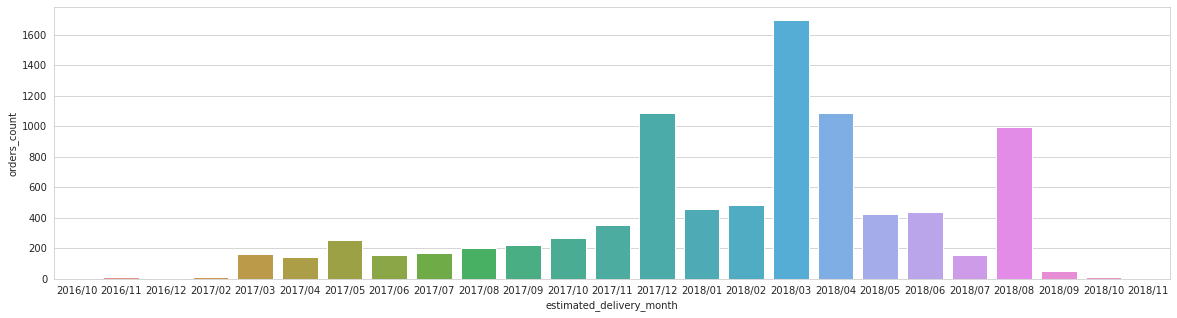

In [79]:
sns.barplot(data = non_delivered_incl_delays.groupby('estimated_delivery_month', as_index = False) \
    .agg({'order_id':'count'}) \
    .sort_values('estimated_delivery_month') \
    .rename(columns={'order_id':'orders_count'}), x = "estimated_delivery_month", y = "orders_count");

📦⛔ **Ответ**
1. Итого, в среднем **355 заказов в месяц не доставляется** по разным причинам, в т.ч. доставляется невовремя.

In [80]:
non_delivered_incl_delays.groupby('estimated_delivery_month', as_index = False) \
    .agg({'order_id':'count'}) \
    .sort_values('estimated_delivery_month') \
    .rename(columns={'order_id':'orders_count'}).mean()

orders_count    354.84
dtype: float64

📦⛔ 
2. **В детализации по причинам, в среднем в месяц не доставляется:**
    * по 365 заказов в связи с просрочкой по дате доставки (с последующей доставкой с опозданием)
    * по 29 заказов в связи с недоступностью заказа
    * по 24 заказа в связи с отменой со стороны пользователя

In [81]:
pd.DataFrame(
    {
        'count_mean_by_month':non_delivered_incl_delays.groupby(['reason_non_delivered','estimated_delivery_month'], as_index = False) \
        .order_id.count() \
        .pivot_table(index = 'estimated_delivery_month',
                     columns = 'reason_non_delivered',
                     values = 'order_id'
                    ) \
        .reset_index() \
        .mean() \
        .sort_values(ascending = False)
    }
)

,count_mean_by_month
reason_non_delivered,
expired,364.571429
unavailable,28.857143
canceled,24.360000


---
#### 3. По каждому товару определить, в какой день недели он чаще всего покупается. 📅

Здесь нам интересны товары в оплаченных неотмененных заказах, т.е. датасет `purchases_marketing_items`.

* В качестве продукта будем рассматривать `product_id`
* Мы будем фокусироваться на дате создания заказа (`order_purchase_timestamp`) как ключевой дате с точки зрения интереса пользователя
* Очевидно, нет смысла рассматривать `product_id` с количеством заказов 7 и менее, поскольку по такому количеству данных нельзя сделать вывод об устойчивой повторяемости заказов в определенные дни недели. Следует эмпирически решить, для товаров с каким числом покупок стоит искать ответ на поставленную задачу.

Создаем столбец с днями недели покупки

In [82]:
purchases_marketing_items['purchase_weekday'] = purchases_marketing_items.order_purchase_timestamp.dt.day_name()

Мы видим, что у 75% подходящих товаров было менее 3 заказов.

In [83]:
purchases_marketing_items['product_id'].value_counts().describe()

count    31974.000000
mean         3.414806
std         10.581083
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        519.000000
Name: product_id, dtype: float64

7 и более заказов только у 3009 товаров:

In [84]:
(purchases_marketing_items['product_id'].value_counts() >= 7).sum()

3009

Следует выбрать товары с оптимальным количеством покупок, чтобы соблюсти баланс между достаточным количеством товаров в ответе на задачу и статистической значимостью выводов. Критерием для отбора выберем отсутствие NaN-значений в итоговой сводной таблице "продукты-дни недели", т.е. каждый продукт должен быть как минимум 1 раз заказан в каждый день недели.

In [85]:
for i in range(7,61):
# Создаем выборку товаров для каждого числа покупок у товара от 7 до 70
    purchases_items_cycle = purchases_marketing_items[
        purchases_marketing_items['product_id'].isin(
            purchases_marketing_items['product_id'].value_counts()[
                purchases_marketing_items['product_id'].value_counts() >= i
            ].index)]
# Считаем количество покупок по каждому продукту х каждому дню
    weekday_freq = purchases_items_cycle.groupby(['product_id','purchase_weekday'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'purchases_count'})
# Перегруппировываем данные: помещаем product_id в столбцы, дни недели в индексы
    weekday_freq_pivot = weekday_freq.pivot(index = 'purchase_weekday', columns = 'product_id', values = 'purchases_count')
    if weekday_freq_pivot.isna().sum().sum() <= 1:
# Печатаем мин. число покупок у товаров для включения в выборку; число пропусков; число товаров в выборке
        print(i,weekday_freq_pivot.isna().sum().sum(),weekday_freq_pivot.shape[1])

45 1 200
46 1 193
47 1 187
48 1 182
49 1 177
50 1 172
51 1 167
52 1 164
53 0 160
54 0 154
55 0 150
56 0 145
57 0 140
58 0 134
59 0 131
60 0 129


Нам подходят продукты с числом покупок 53 и более.

In [86]:
# Отбираем товары с нужным числом покупок
purchases_items_final = purchases_marketing_items[
    purchases_marketing_items['product_id'].isin(
        purchases_marketing_items['product_id'].value_counts()[
            purchases_marketing_items['product_id'].value_counts() >= 53
        ].index)]

# Считаем количество покупок по каждому продукту х каждому дню
weekday_freq = purchases_items_final.groupby(['product_id','purchase_weekday'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'purchases_count'})

# Перегруппировываем данные: помещаем product_id в столбцы, дни недели в индексы
weekday_freq_pivot = weekday_freq.pivot(index = 'purchase_weekday', columns = 'product_id', values = 'purchases_count')

In [87]:
weekday_freq_pivot

product_id,0152f69b6cf919bcdaf117aa8c43e5a2,054515fd15bc1a2029f10de97ffa9120,06c6e01186af8b98ee1fc9e01f9471e9,06edb72f1e0c64b14c5b79353f7abea3,08574b074924071f4e201e151b152b4e,0a57f7d2c983bcf8188589a5fea4a8da,0aabfb375647d9738ad0f7b4ea3653b1,0bcc3eeca39e1064258aa1e932269894,0d85c435fd60b277ffb9e9b0f88f927a,11875b30b49585209e608f40e8082e65,...,f35927953ed82e19d06ad3aac2f06353,f40876e0ef3cd5f9132b1f16b04b1346,f4f67ccaece962d013a4e1d7dc3a61f7,f71973c922ccaab05514a36a8bc741b8,f71f42e2381752836563b70beb542f80,f7a17d2c51d9df89a4f1711c4ac17f33,fb55982be901439613a95940feefd9ee,fbc1488c1a1e72ba175f53ab29a248e8,fbce4c4cb307679d89a3bf3d3bb353b9,fc1d8637c0268af3db482c14b7ef8e75
purchase_weekday,,,,,,,,,,,,,,,,,,,,,
Friday,5,10,6,24,17,4,13,19,11,9,...,10,6,14,10,12,10,14,11,3,2
Monday,8,10,5,24,24,22,27,21,12,11,...,11,11,6,13,4,9,17,10,3,10
Saturday,12,5,5,19,12,11,13,16,6,5,...,3,4,8,8,8,7,11,11,11,5
Sunday,6,6,9,10,11,10,18,7,9,7,...,4,8,3,8,4,8,6,7,6,9
Thursday,11,8,14,17,11,9,24,14,9,12,...,4,6,6,6,13,6,14,5,11,11
Tuesday,4,3,8,28,17,19,28,15,15,14,...,14,10,14,12,8,14,11,5,12,12
Wednesday,15,13,10,17,18,11,17,23,9,7,...,11,10,5,6,5,8,11,9,14,7


📅 **Ответ**  *(без учета статистической значимости разницы популярности дней недели у товаров, т.е. при 5 покупках в пятницу и 6 покупках в субботу в ответ пойдет суббота)*

In [88]:
weekday_freq_df = pd.DataFrame(weekday_freq_pivot.idxmax()).reset_index().rename(columns = {0:'most_freq_weekday'})
weekday_freq_df

,product_id,most_freq_weekday
0,0152f69b6cf919bcdaf117aa8c43e5a2,Wednesday
1,054515fd15bc1a2029f10de97ffa9120,Wednesday
2,06c6e01186af8b98ee1fc9e01f9471e9,Thursday
3,06edb72f1e0c64b14c5b79353f7abea3,Tuesday
4,08574b074924071f4e201e151b152b4e,Monday
...,...,...
155,f7a17d2c51d9df89a4f1711c4ac17f33,Tuesday
156,fb55982be901439613a95940feefd9ee,Monday
157,fbc1488c1a1e72ba175f53ab29a248e8,Friday
158,fbce4c4cb307679d89a3bf3d3bb353b9,Wednesday


---
**4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Учесть, что внутри месяца может быть не целое количество недель (в ноябре 2021 года 4,28 недели).**

К этой задаче лучше подойти с учетом того, сколько товаров покупал каждый пользователь в рамках заказа. Для этого создадим датасет `pmi_customers_df`.

Таким образом, от нас требуется по каждому пользователю посчитать, сколько покупок он совершил в каждом месяце, когда он был активен, если бы он покупал каждую неделю этого месяца. С учетом того, что большинство пользователей совершили лишь 1 покупку, наша метрика будет для большинства пользователей дробным числом: например, за месяц Х покупатель совершил 0,25 покупки в неделю.

In [89]:
# purchases_marketing_items + customers_df = pmi_customers_df
pmi_customers_df = purchases_marketing_items.merge(customers_df, on = 'customer_id', how = 'inner')
pmi_customers_df.shape

(109185, 24)

Для решения задачи посчитаем, сколько каждый пользователь купил товаров в каждом месяце, и поделим на количество недель в этом месяце. 
С учетом, что в месяце могут встречаться неполные недели (например, начинается месяц в воскресенье, заканчивается во вторник, таким образом в месяц попадают 2 неполные недели), при определении количества недель в месяце можно поступить двумя разными способами:
1. Учитывать неполные недели как полные: даже если месяц начался в воскресенье, и закончился во вторник, в месяц войдут обе эти недели, и таким образом в месяце может оказаться 6 недель.
2. Считать количество недель в месяце дробным числом, т.е. все дни из неполных недель учитываются в дробной части количества недель.

Более логичным представляется второй способ: так число недель в году не задвоится, а число покупок в неделю не будет казаться искусственно заниженным.

Создадим колонки с указанием месяца совершенной покупки и количества дней в этом месяце.

In [90]:
pmi_customers_df['year_month'] = pmi_customers_df.order_purchase_timestamp.dt.strftime('%Y/%m')
pmi_customers_df['weeks_in_month'] = (pmi_customers_df['order_purchase_timestamp'].dt.daysinmonth) / 7
pmi_customers_df[['customer_unique_id','order_id','year_month','weeks_in_month']].head()

,customer_unique_id,order_id,year_month,weeks_in_month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017/10,4.428571
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018/07,4.428571
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018/08,4.428571
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017/11,4.285714
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018/02,4.000000


In [91]:
purchases_by_users_pmi = pmi_customers_df.groupby(['customer_unique_id','year_month', 'weeks_in_month'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'purchases_count'})
purchases_by_users_pmi = purchases_by_users_pmi.sort_values(by = 'purchases_count', ascending = False)
purchases_by_users_pmi.head()

,customer_unique_id,year_month,weeks_in_month,purchases_count
73879,c8460e4251689ba205045f3ea17884a1,2018/08,4.428571,24
25551,4546caea018ad8c692964e3382debd19,2017/07,4.428571,21
72308,c402f431464c72e27330a67f7b94d4fb,2018/02,4.000000,20
38954,698e1cf81d01a3d389d96145f7fa6df8,2017/08,4.428571,20
5677,0f5ac8d5c31de21d2f25e24be15bbffb,2017/11,4.285714,18


In [92]:
purchases_by_users_pmi['purchases_by_week'] = purchases_by_users_pmi.purchases_count / purchases_by_users_pmi.weeks_in_month

**💰 Ответ**.

Можно сказать, что если бы пользователь с наибольшим средним числом покупок в неделю покупал равномерно в течение месяца, он бы совершал 5,4 покупки в неделю в этом месяце (авг 2018).

In [93]:
purchases_by_users_pmi[['customer_unique_id','year_month','purchases_by_week']]

,customer_unique_id,year_month,purchases_by_week
73879,c8460e4251689ba205045f3ea17884a1,2018/08,5.419355
25551,4546caea018ad8c692964e3382debd19,2017/07,4.741935
72308,c402f431464c72e27330a67f7b94d4fb,2018/02,5.000000
38954,698e1cf81d01a3d389d96145f7fa6df8,2017/08,4.516129
5677,0f5ac8d5c31de21d2f25e24be15bbffb,2017/11,4.200000
...,...,...,...
33224,59e6feff6b7bdc0b1b875e377e4acce0,2018/06,0.233333
33223,59e66c94d154429f52f83540f49d2e28,2017/11,0.233333
33221,59e48acde78e7f413acac918d1d07001,2017/09,0.233333
33220,59e1e2b60e539a256e9ae81b4d4ef2e8,2017/07,0.225806


---
**5. Провести когортный анализ пользователей. Какая когорта в период с января по декабрь имела самый высокий retention на 3й месяц?** 👥

**Когортный анализ** заключается в разделении пользователей на группы (когорты) в зависимости от даты какого-то значимого события, которое произошло с этими пользователями, и сравнительном анализе поведения когорт во времени на основе различных метрик. Нам нужно проанализировать метрику **Retention rate** — коэффициент удержания пользователей. 

* В качестве критерия объединения в когорты логично взять месяц создания первого заказа — момент превращения в клиента компании.
* В этом кейсе будем рассматривать только целые заказы, а не отдельные товары, т.к. если клиент заказал хотя бы 1 товар после первой покупки, его можно считать активным (`retained`). 
* Для анализа повторных покупок нам понадобится уникальный id пользователя, поэтому нам нужен объединенный датасет `pmo_customers_df`.
* В качества периода для когортного анализа нам нужно взять январь-декабрь, т.е. нас интересуют когорты, формировавшиеся с января по декабрь. Поскольку в датасетах мы имеем данные за сентябрь-октябрь 2016 — сентябрь-октябрь 2018, возьмем январь 2017 года в качестве начала наблюдений. С верхней границей когортного анализа разберемся, когда найдем месяц первой покупки каждого пользователя.

In [94]:
cohort_data = pmo_customers_df.query('order_purchase_timestamp >= "2017-01-01 00:00:00"')

Создаем в этом датасете колонки с датами в формате год-месяц:
1. Дата данного заказа `order_month`
2. Дата первого заказа этого уникального пользователя `first_month`

In [95]:
cohort_data['order_month'] = cohort_data.order_purchase_timestamp.dt.strftime('%Y/%m')

Колонку с первым заказом пользователя создадим способом "self-join" — примерджим колонку с нужными данными к самой себе по `customer_unique_id`. 

In [96]:
cohort_data = cohort_data.merge(cohort_data.groupby('customer_unique_id').order_purchase_timestamp.min(),
                                on='customer_unique_id',
                                suffixes=('', '_first_month')) \
    .rename(columns = {'order_purchase_timestamp_first_month':'first_month'})
cohort_data.first_month = cohort_data.first_month.dt.strftime('%Y/%m')

Так как нам нужны когорты, формировавшиеся с января по декабрь, мы можем оставить только `first_month` до декабря 2017 года включительно.

In [97]:
cohort_data = cohort_data.query('first_month <= "2017/12"')

Составим сводную таблицу, показывающую, сколько уникальных пользователей той или иной когорты совершают покупки в последующие месяцы.

In [98]:
cohorts = cohort_data.pivot_table(
    index = 'first_month', 
    columns = 'order_month', 
    values = 'customer_unique_id', 
    aggfunc='nunique')

Для красоты и простоты восприятия сделаем из нее heatmap.

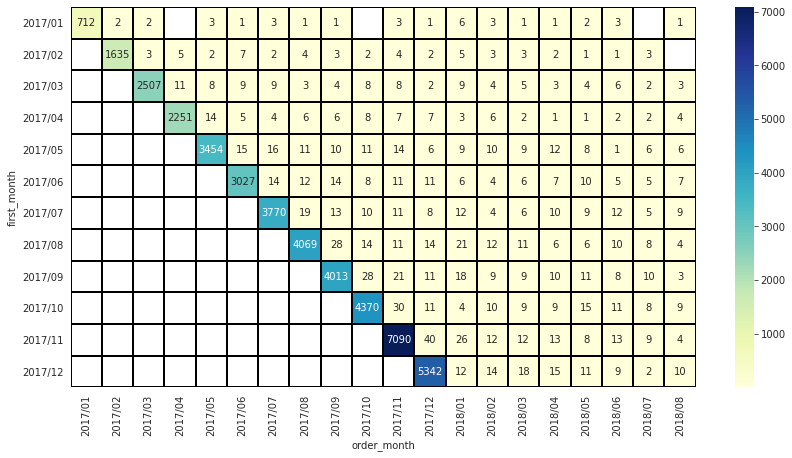

In [99]:
plt.figure(figsize=(14, 7)) # рисуем табличку

sns.heatmap(
    cohorts,# какую табличку отображаем
    annot=True,# показываем цифры 
    fmt='.0f',# не показываем дробные значения, показываем целые
    linewidths=1, # толщина линий
    linecolor='black', # цвет линий
    cmap="YlGnBu"# цвет
);

По абсолютным значениям видно, что в ноябре 2017 года присоединилось больше всего пользователей, а в январе 2017 — меньше всего.

---

Расчитаем **retention rate** по каждому месяцу как процент уникальных пользователей когорты, совершавших покупки в каждом месяце, от изначального числа пользователей в когорте.

In [100]:
cohorts_retention_rate = cohorts

# .values переводит df в numpy
# np.diagonal() - это метод numpy, который возвращает главную диагональ в виде 1d array (численность каждой когорты)
cohorts_sizes = cohorts_retention_rate.values.diagonal() 

# одновременно перебираем значения массива s (численность каждой когорты) и строки cohorts_retention_rate
for s, row in zip(cohorts_sizes, cohorts_retention_rate):
    cohorts_retention_rate.loc[row] = (cohorts_retention_rate.loc[row]/s) 

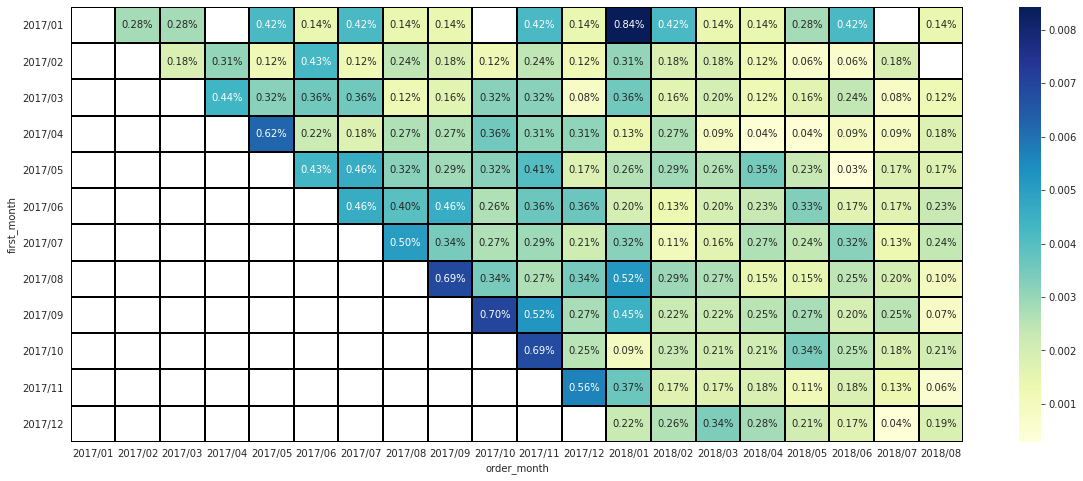

In [101]:
# при построении тепловой карты, чтобы главная диагональ со значениями 100% не перетягивала на себя внимание, замаскируем ее
# np.eye генерирует nd.array с 1 по главной диагонали и нулями в остальном массиве
mask = np.eye(*cohorts_retention_rate.shape)

plt.figure(figsize=(20, 8))
sns.heatmap(
    cohorts_retention_rate,
    annot=True,
    fmt='.2%',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu",
    mask = mask
);

Выявим когорту с самым высоким retention rate на 3 месяц. При поиске 3-го по счёту месяца не будем считать месяц создания когорты. Иными словами, для когорты 2017/01 первым месяцем удержания пользователя будем считать февраль, вторым март, третьим апрель.

Найдем retention rate с помощью метода diagonal(3), который берет значения в 2D-array по диагонали с указанным отступом.

In [102]:
third_month_rr = pd.DataFrame(
    data = cohorts_retention_rate.values.diagonal(3)*100,
    index = cohorts_retention_rate.index,
    columns = ['third_month_retention,%'])

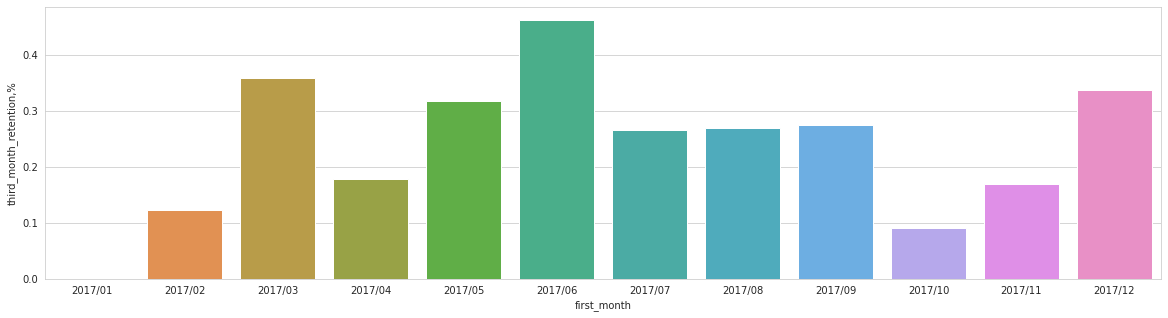

In [103]:
sns.barplot(data = third_month_rr, x = cohorts_retention_rate.index, y = 'third_month_retention,%');

👥 **Ответ. По графику видно, что самый большой retention rate в третьем месяце наблюдается у когорты 2017/06.**

---
**6. Провести RFM-сегментацию пользователей. Описать подход к созданию сегментов. Для каждого RFM-сегмента обозначить границы метрик R,F,M.** 👨🏼👩🏻

В RFM-анализе обычно берутся следующие метрики: 
* R — время от последней покупки пользователя до текущей даты, 
* F — суммарное количество покупок у пользователя за всё время, 
* M — сумма покупок за всё время. 

Здесь стоит задача сегментирования пользователей по их покупательской активности, поэтому нам важно учесть разницу между клиентами, заказывавшими лишь 1 товар, и клиентами, заказывавшими много товаров.
Нам понадобится как информация об уникальных пользователях, так и товарах в заказе, поэтому нам нужны данные из всех датасетов. Воспользуемся ранее созданным `pmi_customers_df`

Посчитаем число дней с каждого заказа до текущей даты (ранее найденной последней даты в датасете). Дальше это поможет нам найти **Recency**, т.е. время от последней покупки пользователя до текущей даты для каждого пользователя.

In [104]:
pmi_customers_df['days_since_order'] = (now_date - pmi_customers_df.order_purchase_timestamp) / pd.Timedelta(days=1)
pmi_customers_df[['order_purchase_timestamp', 'days_since_order']]

,order_purchase_timestamp,days_since_order
0,2017-10-02 10:56:33,380.273438
1,2018-07-24 20:41:37,84.867141
2,2018-08-08 08:38:49,70.369086
3,2017-11-18 19:28:06,332.918194
4,2018-02-13 21:18:39,245.841424
...,...,...
109180,2018-02-06 12:58:58,253.188426
109181,2017-08-27 14:46:43,416.113600
109182,2018-01-08 21:28:27,281.834618
109183,2018-01-08 21:28:27,281.834618


Обычно RFM-сегментацию проводят за определенный период (например, год) и считают **Frequency** как количество покупок за этот период. Но мы в качестве **Frequency** возьмем общее количество покупок пользователя за все время, поскольку число пользователей с несколькими заказами, как мы выяснили ранее, в датасете крайне мало и ограничение периода одним годом может еще сильнее его сократить.

In [105]:
# для каждого пользователя находим последнюю покупку и считаем его общее количество покупок за все время
rfm_data = pmi_customers_df.groupby('customer_unique_id', as_index=False) \
    .agg({'days_since_order':'min', 'order_id':'count'}) \
    .rename(columns = {'days_since_order':'recency', 'order_id':'frequency'}) \
    .sort_values(by = 'frequency', ascending = False)

In [106]:
rfm_data.head()

,customer_unique_id,recency,frequency
72470,c8460e4251689ba205045f3ea17884a1,70.127118,24
25070,4546caea018ad8c692964e3382debd19,457.965891,21
70921,c402f431464c72e27330a67f7b94d4fb,237.083067,20
38220,698e1cf81d01a3d389d96145f7fa6df8,420.338704,20
5565,0f5ac8d5c31de21d2f25e24be15bbffb,324.189387,18


Примерджим по `customer_unique_id` сгруппированную по уникальным пользователям колонку с суммой всех заказов (**Monetary**) к `rfm_data`:

In [107]:
rfm_data = rfm_data.merge(
    pmi_customers_df.groupby('customer_unique_id', as_index=False) \
        .agg({'price':'sum'}) \
        .rename(columns = {'price':'monetary'}),
    on = 'customer_unique_id',
    how = 'inner')

In [108]:
rfm_data.head()

,customer_unique_id,recency,frequency,monetary
0,c8460e4251689ba205045f3ea17884a1,70.127118,24,4080.00
1,4546caea018ad8c692964e3382debd19,457.965891,21,31.80
2,c402f431464c72e27330a67f7b94d4fb,237.083067,20,2000.00
3,698e1cf81d01a3d389d96145f7fa6df8,420.338704,20,1974.00
4,0f5ac8d5c31de21d2f25e24be15bbffb,324.189387,18,1252.35


Далее сегментируем всех пользователей в зависимости от их активности по метрикам Recency, Frequency, Monetary. 

In [109]:
rfm_data.describe()

,recency,frequency,monetary
count,92552.000000,92552.000000,92552.000000
mean,286.557156,1.179715,141.478110
std,152.223030,0.620150,215.543771
min,44.349549,1.000000,0.850000
25%,163.180382,1.000000,47.650000
50%,267.745046,1.000000,89.660000
75%,394.779899,1.000000,153.900000
max,744.023241,24.000000,13440.000000


Можно заметить, что по метрике **Recency** клиенты распределены более-менее равномерно, в то время как по **Frequency** и **Monetary** большая часть клиентов сосредоточена в зонах низких значений и лишь крохотная часть покупателей имеет высокие значения данных метрик.

По каждой метрике необходимо выбрать диапазоны сегментирования.

Существует 3 подхода, как это можно сделать. В таблице ниже приведены примеры диапазонов, которые можно выделить в рамках каждого из подходов.

|**Одинаковые диапазоны значений**  | **Одинаковое число клиентов** | **Фикс. диапазоны значений**
|---|---         | --- 
|**Recency** — диапазоны по 100 дней: `[1,101)`;`[101,201)`;`[201,301)`...|Например, по квантилям. **Recency** — диапазоны по 25% клиентов: `[44,164)`;`[164,268)`;`[268,395)`...|**Frequency** — диапазоны исходя из распределения:`[1,2)`;`[2,3)`;`[3,4)`;`[4,24]`...

Источник: https://habr.com/ru/post/497356/

Чтобы решить, какой подход использовать, изучим распределения более подробно. Построим гистограммы. Для каждой метрики методом подбора найден способ задания диапазонов, отражающий распределение значений наиболее наглядно.

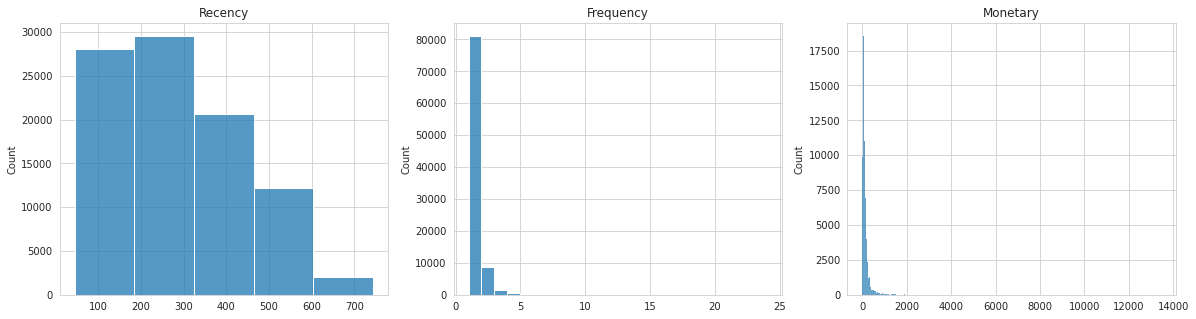

In [110]:
plt.rcParams["figure.figsize"] = (20,5)
fig, axes = plt.subplots(1, 3)

# Recency
sns.histplot(ax=axes[0], data = rfm_data.recency, bins = 5)
axes[0].set_title('Recency')
axes[0].set(xlabel=None)

# Frequency
sns.histplot(ax=axes[1], data = rfm_data.frequency, binwidth = 1)
axes[1].set_title('Frequency')
axes[1].set(xlabel=None)

# Monetary
sns.histplot(ax=axes[2], data = rfm_data.monetary, bins = 500)
axes[2].set_title('Monetary')
axes[2].set(xlabel=None);

Для **Recency** данные хорошо вписываются в 5 одинаковых диапазонов значений. Запишем соответствующие метки клиентов в переменную `recency_classes` с помощью функции `np.histogram_bin_edges`, находящей границы диапазонов, и функции `np.digitize`, которая каждому значению из `rfm_data.recency` поставит в соответствие метку диапазона от 1 до 5. При этом все диапазоны, кроме последнего справа, будут полуоткрытыми. Например, для диапазонов [1, 2, 3, 4] первый диапазон будет `[1, 2)`, но последний будет закрытым: `[3, 4]`.

(https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy.histogram)

In [111]:
recency_edges = np.histogram_bin_edges(rfm_data.recency, bins = 5)
recency_classes = np.fmin(np.digitize(rfm_data.recency, recency_edges), 5)

# количество наблюдений каждого класса
unique, counts = np.unique(recency_classes, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    1 28081]
 [    2 29566]
 [    3 20650]
 [    4 12194]
 [    5  2061]]


С **Frequency** и **Monetary** сложнее. Построим для них отдельные графики распределений и найдем подходящие диапазоны для этих метрик.

Начнем с **Frequency**. 

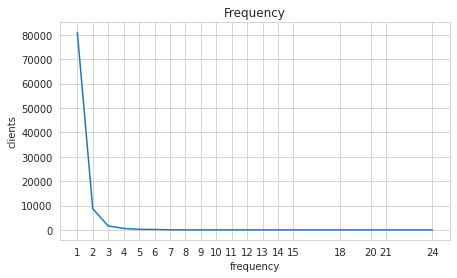

In [112]:
freq_counts = rfm_data.frequency.value_counts().reset_index().rename(columns = {'index':'frequency','frequency':'clients'})

plt.rcParams["figure.figsize"] = (7,4)
fig, axes = plt.subplots()

sns.lineplot(data = freq_counts, x = "frequency", y = "clients")
axes.set_title('Frequency')

plt.xticks(freq_counts.frequency);

Для **Frequency** наибольшее число клиентов имеют 1 покупку, при переходе к 2 покупкам количество покупателей резко сокращается. Между числом покупок 3, 4 еще можно заметить разницу в числе клиентов, но при значениях метрики в диапазоне`[4;24]` количество клиентов уже практически неразличимо, т.к. крайне близко к нулю. Поскольку для этой метрики небольшое количество уникальных значений, границы диапазонов легко задать вручную. Пусть всего будет 4 диапазона.

(array([81085.,  8688.,  1626.,  1153.]),
 array([ 1.,  2.,  3.,  4., 24.]),
 <a list of 4 Patch objects>)

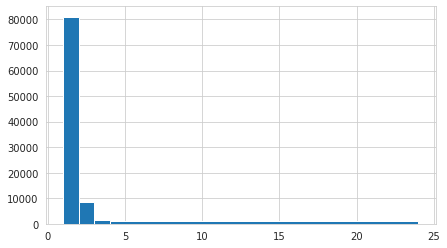

In [113]:
freq_edges = np.array([1.0, 2.0, 3.0, 4.0, 24.0])

plt.rcParams["figure.figsize"] = (7,4)
plt.hist(np.array(rfm_data.frequency), bins=freq_edges)

In [114]:
freqency_classes = np.fmin(np.digitize(rfm_data.frequency, freq_edges), 4)

# количество наблюдений каждого класса
unique, counts = np.unique(freqency_classes, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    1 81085]
 [    2  8688]
 [    3  1626]
 [    4  1153]]


Теперь с **Monetary**. Уникальных значений здесь гораздо больше, чем во **Frequency**, поэтому выбрать точные границы диапазонов тяжелее. 

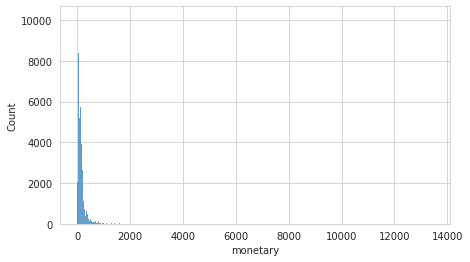

In [115]:
sns.histplot(data = rfm_data.monetary, bins = 1000);

Основная часть данных лежит, судя по детальной гистограмме, в пределах 2000 д.е., верхний диапазон обозначим как `[2000;max]`, а данные в пределах 2000 д.е. разобьем на 4 диапазона по квартилям.

In [116]:
monetary_below_2000 = rfm_data[rfm_data.monetary < 2000].monetary

In [117]:
monetary_edges = monetary_below_2000.quantile([0, .25, .5, .75]).values
monetary_edges = np.append(monetary_edges, [2000, 13440])

In [118]:
monetary_classes = np.fmin(np.digitize(rfm_data.monetary, monetary_edges), 5)

# количество наблюдений каждого класса
unique, counts = np.unique(monetary_classes, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    1 23103]
 [    2 23061]
 [    3 23144]
 [    4 23105]
 [    5   139]]


Добавим колонки с обозначением классов клиентов к датафрейму.

In [119]:
rfm_data['R_class']=pd.Series(recency_classes).astype(str)
rfm_data['F_class']=pd.Series(freqency_classes).astype(str)
rfm_data['M_class']=pd.Series(monetary_classes).astype(str)

Сейчас для метрик F и M у нас нарушена стандартная для RFM-анализа логика выставления меток. У нас получилось так, что чем больше значения по этим метрикам, тем больше значение класса, хотя лучшие клиенты в классическом RFM-анализе имеют значения меток ближе к 1. Необходимо сделать замену значений в столбцах `F_class` и `M_class`.

In [120]:
pd.concat([rfm_data.head(), rfm_data.tail()])

,customer_unique_id,recency,frequency,monetary,R_class,F_class,M_class
0,c8460e4251689ba205045f3ea17884a1,70.127118,24,4080.00,1,4,5
1,4546caea018ad8c692964e3382debd19,457.965891,21,31.80,3,4,1
2,c402f431464c72e27330a67f7b94d4fb,237.083067,20,2000.00,2,4,5
3,698e1cf81d01a3d389d96145f7fa6df8,420.338704,20,1974.00,3,4,4
4,0f5ac8d5c31de21d2f25e24be15bbffb,324.189387,18,1252.35,2,4,4
92547,5a86385578ed60106d47b031a96b5f62,254.896979,1,120.00,2,1,3
92548,5a853168709c620a1591b3392823bc24,278.815394,1,39.90,2,1,1
92549,5a83ed9c112da985d12f9d1a3762008c,96.148947,1,329.00,1,1,4
92550,5a83824981b849806e4d02b7c7a18950,514.955359,1,52.90,4,1,2
92551,ffffd2657e2aad2907e67c3e9daecbeb,532.883021,1,56.99,4,1,2


In [121]:
rfm_data['F_class'] = rfm_data['F_class'].replace(
    to_replace=['4','3','2','1'], 
    value=['1','2','3','4'])

In [122]:
rfm_data['M_class'] = rfm_data['M_class'].replace(
    to_replace=['5','4','3','2','1'], 
    value=['1','2','3','4','5'])

In [123]:
rfm_data['RFM'] = rfm_data['R_class'] + rfm_data['F_class'] + rfm_data['M_class']
pd.concat([rfm_data.head(), rfm_data.tail()])

,customer_unique_id,recency,frequency,monetary,R_class,F_class,M_class,RFM
0,c8460e4251689ba205045f3ea17884a1,70.127118,24,4080.00,1,1,1,111
1,4546caea018ad8c692964e3382debd19,457.965891,21,31.80,3,1,5,315
2,c402f431464c72e27330a67f7b94d4fb,237.083067,20,2000.00,2,1,1,211
3,698e1cf81d01a3d389d96145f7fa6df8,420.338704,20,1974.00,3,1,2,312
4,0f5ac8d5c31de21d2f25e24be15bbffb,324.189387,18,1252.35,2,1,2,212
92547,5a86385578ed60106d47b031a96b5f62,254.896979,1,120.00,2,4,3,243
92548,5a853168709c620a1591b3392823bc24,278.815394,1,39.90,2,4,5,245
92549,5a83ed9c112da985d12f9d1a3762008c,96.148947,1,329.00,1,4,2,142
92550,5a83824981b849806e4d02b7c7a18950,514.955359,1,52.90,4,4,4,444
92551,ffffd2657e2aad2907e67c3e9daecbeb,532.883021,1,56.99,4,4,4,444


Визуализируем количество клиентов разных классов

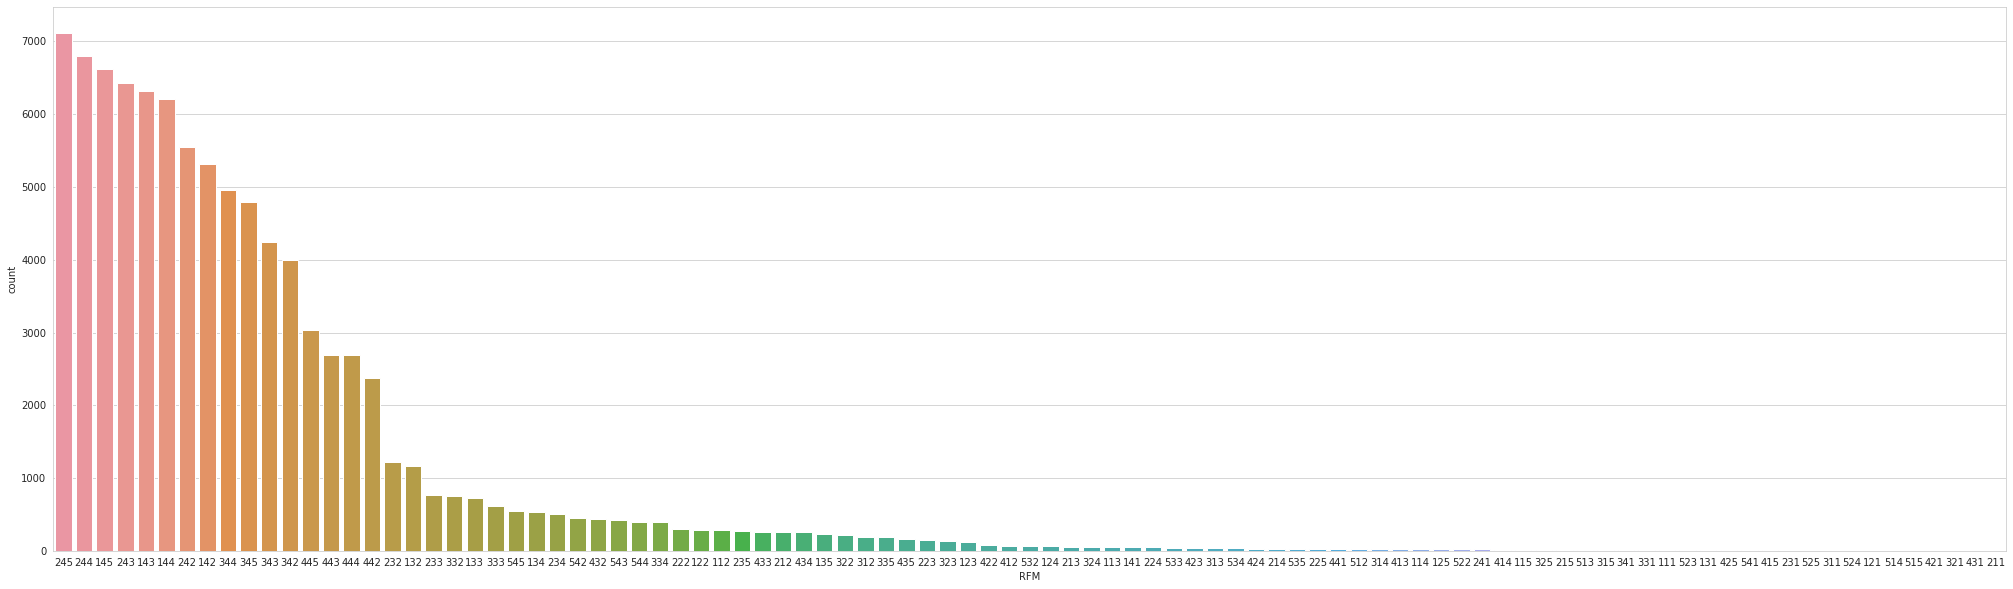

In [124]:
# по количеству клиентов
plt.rcParams["figure.figsize"] = (35,10)
sns.countplot(data=rfm_data, x="RFM", order = rfm_data['RFM'].value_counts().index)

In [125]:
rfm_data.RFM.nunique()

95

С 95 сегментами довольно тяжело работать, поэтому лучше оставить наиболее примечательные из них. Начнем с того, чтобы оставить только сегменты, где не менее 100 клиентов.

In [126]:
RFM_large_segments = rfm_data.groupby('RFM',as_index = False).agg({'customer_unique_id':'count'}).query('customer_unique_id > 100')

In [127]:
rfm_data_priority = rfm_data[rfm_data.RFM.isin(RFM_large_segments.RFM)]

Выделим следующие сегменты:
* Сегменты с наименьшим количеством дней с прошлой покупки и единственной покупкой: **newcomer**
* Сегменты с наибольшим количеством дней с прошлой покупки и единственной покупкой: **dead**
* Недавние покупатели с большой суммой и количеством покупок: **best_customer**
* Сегменты со средним количеством дней с прошлой покупки и большим количеством и суммой покупок: **priority_for_retention**

In [128]:
segt_map = {
    r'15': 'newcomers',
    r'55': 'dead',
    r'1[1-2][1-2]': 'best_customers',
    r'[2-3][1-2][1-2]': 'priority_for_retention',
}

rfm_data_priority['Segment'] = rfm_data_priority['RFM']
rfm_data_priority['Segment'] = rfm_data_priority['Segment'].replace(segt_map, regex=True)
rfm_data_priority.head()

,customer_unique_id,recency,frequency,monetary,R_class,F_class,M_class,RFM,Segment
3,698e1cf81d01a3d389d96145f7fa6df8,420.338704,20,1974.00,3,1,2,312,priority_for_retention
4,0f5ac8d5c31de21d2f25e24be15bbffb,324.189387,18,1252.35,2,1,2,212,priority_for_retention
5,eae0a83d752b1dd32697e0e7b4221656,176.016250,15,1821.73,1,1,2,112,best_customers
7,8d50f5eadf50201ccdcedfb9e2ac8455,57.927685,15,714.63,1,1,2,112,best_customers
8,3e43e6105506432c953e165fb2acf44c,231.953924,14,1000.85,2,1,2,212,priority_for_retention


... И передадим сегментацию маркетологам для дальнейшего использования)